In [1]:
import torch
import MySQLdb
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.utils.data.sampler as smp
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import IPython.display
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image

import dataset
import dataLoader
import configure as cf
import plot_utils as utils
import train_function as train

In [2]:
#define transform function, define trainset and valset
#AlexNet requires the input size of 224*224*3
imgTransform = transforms.Compose([transforms.Scale((224)),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor()                       
                            ])
trainLoader, valLoader = dataLoader.get_train_valid_loader(cf.photo_url,50,32,'food',imgTransform,0.1,-1)

food
After search photo, find result: 121267
Start search stars for each photo.


A Jupyter Widget

In [3]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [4]:
#define train model
def train_model(network, criterion, optimizer, trainLoader, valLoader, n_epochs = 10, use_gpu = True):
    
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        for (i, (inputs, stars)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            stars = Variable(stars.type(torch.FloatTensor))
            if inputs.size(0)<50 or stars.size(0)<50: break
            
            if use_gpu:
                inputs = inputs.cuda()
                stars = stars.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, stars)

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            #set a rule: if prediction values is between real_value-0.5 and real_value+0.5, correct+1
            cum_loss += loss.data[0]
            pre_star = outputs.data
            larger = (pre_star.view(50) >= (stars.data-0.5)).type(torch.IntTensor)
            littler = (pre_star.view(50) <= (stars.data+0.5)).type(torch.IntTensor)
            correct += (larger+littler).eq(2).sum() 
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        train_accuracy.append(100 * correct / counter)
        train_loss.append(cum_loss / (1 + i))

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, stars)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            stars = Variable(stars.type(torch.FloatTensor))
            if inputs.size(0)<50 or stars.size(0)<50: break
            
            if use_gpu:
                inputs = inputs.cuda()
                stars = stars.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, stars)

            # logging information.
            cum_loss += loss.data[0]
            pre_star = outputs.data
            larger = (pre_star.view(50) >= (stars.data-0.5)).type(torch.IntTensor)
            littler = (pre_star.view(50) <= (stars.data+0.5)).type(torch.IntTensor)
            correct += (larger+littler).eq(2).sum() 
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        val_accuracy.append(100 * correct / counter)
        val_loss.append(cum_loss / (1 + i))
    return [train_accuracy,val_accuracy,train_loss,val_loss]
            
#define learningRate
learningRate = 1e-3

# Definition of our network.
# network = models.alexnet(pretrained = True, num_classes=1)
network = AlexNet()

#Definition of our loss.
#The MSELoss function (input? output?)
criterion = nn.MSELoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

result = []
# Train the previously defined model.
result = train.train_model(network, criterion, optimizer, trainLoader, valLoader,
                           n_epochs = 10, use_gpu = True)

A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/jiefu_liang0225/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/jiefu_liang0225/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jiefu_liang0225/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

trainLoss data: 
[1.0992162380329957, 0.4526633903124702, 0.44864579535317356, 0.44746516155988986, 0.4466513820422778, 0.44623753005736033, 0.44569859687856966, 0.4448833346339566, 0.4447353106780843, 0.4438340705226147]
valLoss data: 
[0.46012598214563255, 0.4561855620589138, 0.45565873950966135, 0.4554037077983549, 0.4553787704587968, 0.45457495551956584, 0.45470491273344055, 0.4546870568320771, 0.4537944695181098, 0.4522813764239146]


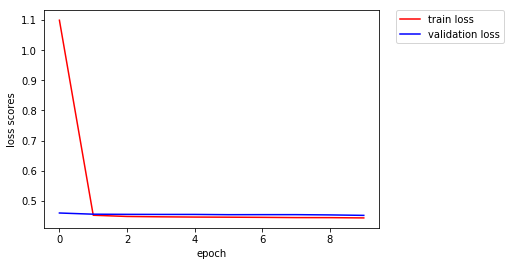

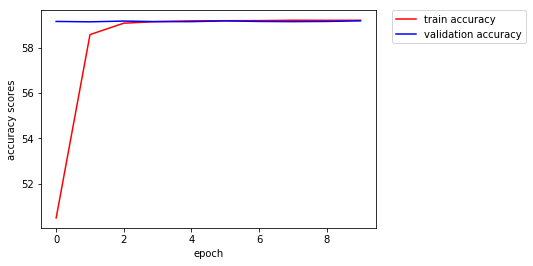

In [5]:
trainLoss = result[2]
for i in range (0, len(trainLoss)):
    trainLoss[i] *= 50
valLoss = result[3]
for i in range (0, len(valLoss)):
    valLoss[i] *= 50
print("trainLoss data: ")
print(trainLoss)
print("valLoss data: ")
print(valLoss)
utils.plot_loss(trainLoss,valLoss)
utils.plot_accuracy(result[0],result[1])